In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import calendar as cal
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV


from IPython.core.display import HTML
%matplotlib inline

In [2]:
df = pd.read_csv('https://s3.us-east-2.amazonaws.com/ads-demo1/E_Dataset.csv',parse_dates=['date'])

In [3]:
pp.ProfileReport(df)

Number of variables,29
Number of observations,19735
Total Missing (%),0.0%
Total size in memory,4.4 MiB
Average record size in memory,232.0 B
Numeric,25
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,3


## Feature Engineering

In [4]:
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['weekNumberInYear'] = df['date'].dt.week
df['dayOfMonth'] = df['date'].dt.day
df['dayInWeek'] = df['date'].dt.dayofweek.apply(lambda x : cal.day_name[x])
df['hourOfDay'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

df['WeekendFlag'] = df['dayInWeek'].apply(lambda x : 1 if (x == 'Saturday') or (x == 'Sunday') else 0).astype('int64')
df['TotalSecondsMidnight'] = (df['date'].dt.hour * 3600) + (df['date'].dt.minute * 60) + (df['date'].dt.second)

dayInWeek = pd.get_dummies(df.dayInWeek,prefix='dayInWeek').astype('int64')
weekendflag = pd.get_dummies(df.WeekendFlag,prefix='weekendflag').astype('int64')

df = pd.concat([df,dayInWeek,weekendflag],axis=1)

In [5]:
features = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 
            'T3','RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8','RH_8', 'T9', 'RH_9', 
            'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint','TotalSecondsMidnight', 
            'dayInWeek_Friday','dayInWeek_Monday', 'dayInWeek_Saturday', 'dayInWeek_Sunday','dayInWeek_Thursday', 'dayInWeek_Tuesday', 'dayInWeek_Wednesday',
            'weekendflag_0', 'weekendflag_1']

In [6]:
df = df[features]

In [7]:
display(HTML(df.head(5).to_html()))

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,61200,0,1,0,0,0,0,0,1,0
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,61800,0,1,0,0,0,0,0,1,0
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,62400,0,1,0,0,0,0,0,1,0
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,63000,0,1,0,0,0,0,0,1,0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,63600,0,1,0,0,0,0,0,1,0


## Train Test Splitting of the Dataframe

In [8]:
X = df.drop('Appliances',axis=1)
y = df['Appliances']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

- Initially, we will use 3 'vanilla' models of Random Forests, Neural Networks and Linear regressors to asses their performance.  
- When we identify the best among the three models, we can proceed ahead to see how we can further enhance its performance.  

## Prediction Models

In [9]:
lm = LinearRegression()
rf = RandomForestRegressor()
nn = MLPRegressor()

- We can see that the data in the **TotalSecondsMidnight** column is not up to scale as compared to other columns.  
- We should scale the dataset before we can plug it in our models for further evaluation.  
- We use the **MinMax scaler** for the job because if we use StandardScaler then some values in the dataset are scaled to -ve, which can give a -ve score for the neural networks.

In [10]:
#Reshaping y to fit the scaler
yte = np.array(y_test).reshape(len(y_test),1)
ytr = np.array(y_train).reshape(len(y_train),1)

scaler = MinMaxScaler()

X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

y_train_scaled = scaler.fit_transform(ytr).ravel()
y_test_scaled = scaler.fit_transform(yte).ravel()

C:\Users\Anuja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
lm.fit(X_train_scaled,y_train_scaled)
rf.fit(X_train_scaled,y_train_scaled)
nn.fit(X_train_scaled,y_train_scaled)

lm_pred = lm.predict(X_test_scaled)
rf_pred = rf.predict(X_test_scaled)
nn_pred = nn.predict(X_test_scaled)

In [12]:
error_metric = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[]})

def model_stats(model,model_name):
    global error_metric
    
    test_data_predictions = model.predict(X_test_scaled)
    train_data_predictions = model.predict(X_train_scaled)
    
    #MAE
    model_mae_train = mean_absolute_error(y_train_scaled,train_data_predictions)
    model_mae_test = mean_absolute_error(y_test_scaled,test_data_predictions)
    
    #RMSE
    model_rmse_train = np.sqrt(mean_squared_error(y_train_scaled,train_data_predictions))
    model_rmse_test = np.sqrt(mean_squared_error(y_test_scaled,test_data_predictions))
    
    #R-Squared
    model_r2_train = r2_score(y_train_scaled,train_data_predictions)
    model_r2_test = r2_score(y_test_scaled,test_data_predictions)
        
    df_local = pd.DataFrame({'Model':[model_name],
                            'r2_train': [model_r2_train],
                            'r2_test': [model_r2_test],
                            'rms_train':[model_rmse_train], 
                            'rms_test': [model_rmse_test],
                            'mae_train': [model_mae_train],
                            'mae_test': [model_mae_test]})
    
    error_metric = pd.concat([error_metric, df_local],sort=True)
    return error_metric

In [13]:
model_stats(lm,'LR')
model_stats(rf,'RF')
model_stats(nn,'NN')

,Model,mae_test,mae_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077096,0.048974,0.112300,0.171899,0.113018,0.086957
0,RF,0.054576,0.012767,0.311394,0.907617,0.099540,0.029044
0,NN,0.058758,0.047127,0.104919,0.155281,0.113487,0.087826


## Hyper Parameter Tuning Using GridSearchCV

In [14]:
param_grid_rf = {'n_estimators':[5,15,30],
                'bootstrap':[True,False],
                'max_depth':[1,10,30]}

param_grid_nn = {'activation': ['tanh', 'relu'], 
                 'solver': ['sgd', 'adam'], 
                 'alpha': [0.0001, 0.05], 
                 'learning_rate': ['constant','adaptive']}

In [15]:
nn_grid = GridSearchCV(MLPRegressor(),
                       param_grid=param_grid_nn,
                       n_jobs=-1,cv=3,
                       refit=True)

nn_grid.fit(X_train_scaled,y_train_scaled)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   15.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': ['constant', 'adaptive'], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.05], 'solver': ['sgd', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [44]:
nn_grid.best_params_

{'activation': 'relu',
 'alpha': 0.05,
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [16]:
model_stats(nn_grid,'Tuned NN Regressor')

,Model,mae_test,mae_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,RF,0.053554,0.012730,0.331053,0.908974,0.098109,0.028830
0,NN,0.062780,0.047942,0.147164,0.172001,0.110776,0.086952
0,Tuned NN Regressor,0.061456,0.048089,0.218727,0.241872,0.106027,0.083203


In [17]:
rf_grid = GridSearchCV(RandomForestRegressor(),
                       param_grid=param_grid_rf,
                       n_jobs=-1,cv=3,refit=True)

rf_grid.fit(X_train_scaled,y_train_scaled)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   44.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 10, 30], 'n_estimators': [5, 15, 30], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [45]:
rf_grid.best_params_

{'bootstrap': True, 'max_depth': 30, 'n_estimators': 30}

In [18]:
model_stats(rf_grid,'Tuned RF Regressor')

,Model,mae_test,mae_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,RF,0.053554,0.012730,0.331053,0.908974,0.098109,0.028830
0,NN,0.062780,0.047942,0.147164,0.172001,0.110776,0.086952
0,Tuned NN Regressor,0.061456,0.048089,0.218727,0.241872,0.106027,0.083203
0,Tuned RF Regressor,0.048716,0.012037,0.398941,0.926991,0.092998,0.025820


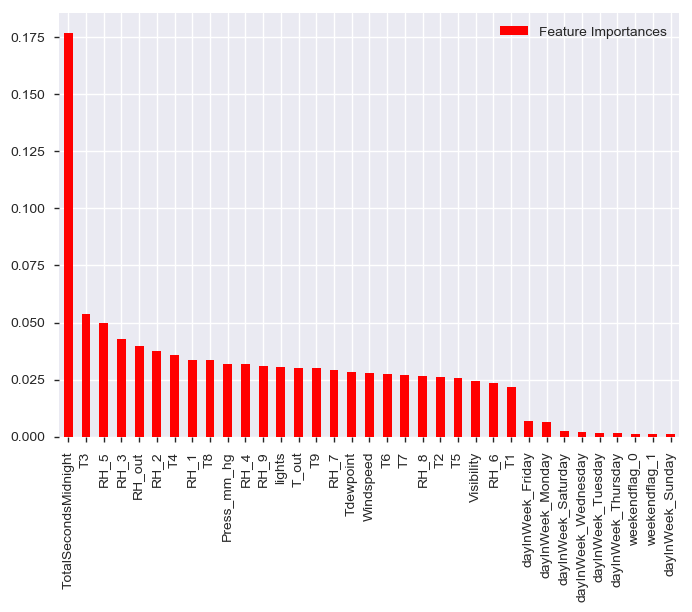

In [29]:
pd.DataFrame(rf.feature_importances_,
             index=X_train.columns,
             columns=['Feature Importances']).sort_values(by='Feature Importances',ascending=False).plot(kind='bar',color='Red')

Since the **Lights** column has a lot of Zeros let us try to evaluate our models performance after removing it from our evaluation to see if the models are a better fit or not.

In [36]:
featuresNoLights = features[2:]
featuresNoLights.append('Appliances')

In [38]:
df_NL = df[featuresNoLights]

In [40]:
display(HTML(df_NL.head().to_html()))

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,TotalSecondsMidnight,dayInWeek_Friday,dayInWeek_Monday,dayInWeek_Saturday,dayInWeek_Sunday,dayInWeek_Thursday,dayInWeek_Tuesday,dayInWeek_Wednesday,weekendflag_0,weekendflag_1,Appliances
0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,61200,0,1,0,0,0,0,0,1,0,60
1,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,61800,0,1,0,0,0,0,0,1,0,60
2,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,62400,0,1,0,0,0,0,0,1,0,50
3,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,63000,0,1,0,0,0,0,0,1,0,50
4,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,63600,0,1,0,0,0,0,0,1,0,60


In [41]:
X_NL = df_NL.drop('Appliances',axis=1)
y_NL = df_NL['Appliances']

X_train_NL, X_test_NL, y_train_NL, y_test_NL = train_test_split(X, y, test_size=0.30, random_state=101)

In [42]:
nl_yte = np.array(y_test_NL).reshape(len(y_test_NL),1)
nl_ytr = np.array(y_train_NL).reshape(len(y_train_NL),1)


X_NL_train_scaled = scaler.fit_transform(X_train_NL)
X_NL_test_scaled = scaler.fit_transform(X_test_NL)

Y_NL_train_scaled = scaler.fit_transform(nl_ytr).ravel()
Y_NL_test_scaled = scaler.fit_transform(nl_yte).ravel()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
nl_lm = LinearRegression()
nl_lm.fit(X_NL_train_scaled,Y_NL_train_scaled)
model_stats(nl_lm,'No Light Linear Model')

,Model,mae_test,mae_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,RF,0.053554,0.012730,0.331053,0.908974,0.098109,0.028830
0,NN,0.062780,0.047942,0.147164,0.172001,0.110776,0.086952
0,Tuned NN Regressor,0.061456,0.048089,0.218727,0.241872,0.106027,0.083203
0,Tuned RF Regressor,0.048716,0.012037,0.398941,0.926991,0.092998,0.025820
0,No Light Linear Model,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958


In [47]:
nl_rf = RandomForestRegressor(bootstrap=True, max_depth=30, n_estimators=30)
nl_rf.fit(X_NL_train_scaled,Y_NL_train_scaled)
model_stats(nl_rf,'No Light RF Model')

,Model,mae_test,mae_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,RF,0.053554,0.012730,0.331053,0.908974,0.098109,0.028830
0,NN,0.062780,0.047942,0.147164,0.172001,0.110776,0.086952
0,Tuned NN Regressor,0.061456,0.048089,0.218727,0.241872,0.106027,0.083203
0,Tuned RF Regressor,0.048716,0.012037,0.398941,0.926991,0.092998,0.025820
0,No Light Linear Model,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,No Light RF Model,0.050130,0.012147,0.381984,0.924972,0.094300,0.026175


In [48]:
nl_nn = MLPRegressor(activation='relu',
                     alpha=0.05,
                     learning_rate='adaptive',
                     solver='adam')
nl_nn.fit(X_NL_train_scaled,Y_NL_train_scaled)
model_stats(nl_nn,'No Light NN Model')

,Model,mae_test,mae_train,r2_test,r2_train,rms_test,rms_train
0,LR,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,RF,0.053554,0.012730,0.331053,0.908974,0.098109,0.028830
0,NN,0.062780,0.047942,0.147164,0.172001,0.110776,0.086952
0,Tuned NN Regressor,0.061456,0.048089,0.218727,0.241872,0.106027,0.083203
0,Tuned RF Regressor,0.048716,0.012037,0.398941,0.926991,0.092998,0.025820
0,No Light Linear Model,0.077071,0.048970,0.112461,0.171898,0.113008,0.086958
0,No Light RF Model,0.050130,0.012147,0.381984,0.924972,0.094300,0.026175
0,No Light NN Model,0.085074,0.068221,0.088587,0.095004,0.114517,0.090905


We can observe that after removing the Light column, the model and their efficacy is reduced, hence we can deduce that even though the light column has many zeros it does contribute to the predictions and makes them slightly better.